# Central Pattern Generator for control of quadruped robot

This is part 1 of the Legged robot course's project \#2. We will focus on implementing a montion controller based on a Central Pattern Generato (CPG).

## Importing the required libraries

In [4]:
import time
import numpy as np # numpy library for matrix computatios
from matplotlib import pyplot as plt

from env.quadruped_gym_env import QuadrupedGymEnv
from hopf_network import HopfNetwork

%load_ext autoreload
%autoreload 2

## Note on this notebook vs the hopf_network module

Instead of directly implementing the simulation in the hopf_network module's default function __\_\_main\_\___, we will work it out here in this current notebook. 

This will enable us to test different parameters, perform different graphs, in a reproducible and illustrated step by step fashion. The steps will be explained as needed. 

Finally, we will move the chosen parameters and code to the hopf_network module's default function __\_\_main\_\___, such that it is a standalone module. 

In [5]:
# Initialise dynamic engine of pybullet and we connect it to the Pybullet GUI
ADD_CARTESIAN_PD = True
TIME_STEP = 0.001
foot_y = 0.0838 # this is the hip length 
sideSign = np.array([-1, 1, -1, 1]) # get correct hip sign (body right is negative)

In [ ]:
env = QuadrupedGymEnv(
                  render=True,              # visualize
                  on_rack=False,              # useful for debugging! 
                  isRLGymInterface=False,     # not using RL
                  time_step=TIME_STEP,
                  action_repeat=1,
                  motor_control_mode="TORQUE",
                  add_noise=False,    # start in ideal conditions
                  # record_video=True
                  )

In [ ]:
# After implementing the gait offsets, let's check that everything looks ok (divide by 2pi for clarity)
# initialize Hopf Network, supply gait
print(HopfNetwork(gait="TROT").PHI/(2*np.pi))
print(HopfNetwork(gait="PACE").PHI/(2*np.pi))
print(HopfNetwork(gait="BOUND").PHI/(2*np.pi))
print(HopfNetwork(gait="WALK").PHI/(2*np.pi))

Which seems right !

In [ ]:
# Testing the simulation works, the robot does move according to gravity and small torques...
env.reset()
for i in range(1000):
    env.step(action = np.zeros(12) + 5 ) 

Everything seems to work fine, although there were troubles at the beginning on macOS because of pyqt5.

## Updating the oscillators' states

We will now work on implementing the _integrate_hopf_equations_ method of the HopfNetwork, where we will update the states of the oscillators for each leg : the current aplitudes and phases of each, which we'll later use, mapping them to robot coordinates.

In [ ]:
int_cpg = HopfNetwork(gait="PACE")
int_X = np.array([int_cpg.X])
print(f"\nOsccillator state before : \n{int_cpg.X}")
int_cpg._integrate_hopf_equations()
int_X = np.append(int_X, [int_cpg.X], axis=0)
print(f"\nOsccillator state after one integration : \n{int_cpg.X}")
for i in range(2000):
    int_cpg._integrate_hopf_equations()
    int_X = np.append(int_X, [int_cpg.X], axis=0)
print(f"\nOsccillator state after many integrations : \n{int_cpg.X}")

Let's look at it in plots :

In [ ]:
x = range(int_X.shape[0])

fig, axs = plt.subplots(2, 4, sharex=True, sharey='row')

axs[0, 0].plot(x, int_X[:,0,0])
axs[0, 0].set_title("r0")
axs[0, 1].plot(x, int_X[:,0,1])
axs[0, 1].set_title("r1")
axs[0, 2].plot(x, int_X[:,0,2])
axs[0, 2].set_title("r2")
axs[0, 3].plot(x, int_X[:,0,3])
axs[0, 3].set_title("r3")

axs[1, 0].plot(x, int_X[:,1,0])
axs[1, 0].set_title("θ0")
axs[1, 1].plot(x, int_X[:,1,1])
axs[1, 1].set_title("θ1")
axs[1, 2].plot(x, int_X[:,1,2])
axs[1, 2].set_title("θ2")
axs[1, 3].plot(x, int_X[:,1,3])
axs[1, 3].set_title("θ3");

We can check that indeed the oscillator phases respect the gait timing. This looks ok.

Now, we implement the update function of the HopfNetwork class. We simply map the cpg oscillator states to cartesion coordinates for the feet x and z positions (y are constant).

In [ ]:
int_cpg = HopfNetwork(gait="PACE")
x, z = int_cpg.update()
x_arr = np.array([x])
z_arr = np.array([z])
print(f"\nPositions for first step : \nx: {x_arr} \nz: {z_arr}")
x, z = int_cpg.update()
x_arr = np.append(x_arr, [x], axis=0)
z_arr = np.append(z_arr, [z], axis=0)
print(f"\nPositions after next step : \nx: {x} \nz: {z}")

for i in range(2000):
    x, z = int_cpg.update()
    x_arr = np.append(x_arr, [x], axis=0)
    z_arr = np.append(z_arr, [z], axis=0)
print(f"\nPositions after many steps : \nx: {x} \nz: {z}")

x = range(x_arr.shape[0])

fig, axs = plt.subplots(2, 4, sharex=True, sharey='row')

# Order is FR, FL, RR, RL
axs[0, 0].plot(x, x_arr[:,0])
axs[0, 0].set_title("x FR")
axs[0, 1].plot(x, x_arr[:,1])
axs[0, 1].set_title("x FL")
axs[0, 2].plot(x, x_arr[:,2])
axs[0, 2].set_title("x RR")
axs[0, 3].plot(x, x_arr[:,3])
axs[0, 3].set_title("x RL")

axs[1, 0].plot(x, z_arr[:,0])
axs[1, 0].set_title("z FR")
axs[1, 1].plot(x, z_arr[:,1])
axs[1, 1].set_title("z FL")
axs[1, 2].plot(x, z_arr[:,2])
axs[1, 2].set_title("z RR")
axs[1, 3].plot(x, z_arr[:,3])
axs[1, 3].set_title("z RL");

We can see that the feet positions, in the referential of the robot, are indeed moving as expected, with regular oscillations, with the robot height as 0.25, we can see that the feet touch the ground and "penetrate" about (from -0.25 to -0.26) 0.01, but this is not actual ground penetration, it will only force to push strongly against the ground.

## Motor control

Now let's continue towards actual control. Let's see how motor angles and velocities are :

In [ ]:
print(f"motor angles:\n{env.robot.GetMotorAngles()}")
print(f"motor velocities:\n{env.robot.GetMotorVelocities()}")

From these current angles and velocities, we'll set controls with a PD controller. Let's run a simulation with a few parameters. We can play with these prameters, and visualize what happens.

In [ ]:
# initialize Hopf Network, supply gait
cpg = HopfNetwork(
                mu=1**2,                # converge to sqrt(mu)
                omega_swing=10*2*np.pi,  # MUST EDIT
                omega_stance=1*2*np.pi, # MUST EDIT
#                 gait="TROT",            # change depending on desired gait
#                 gait="PACE",            # change depending on desired gait
                gait="BOUND",            # change depending on desired gait
#                 gait="WALK",            # change depending on desired gait
                coupling_strength=1,    # coefficient to multiply coupling matrix
                couple=True,            # should couple
                time_step=TIME_STEP,    # time step 
                ground_clearance=0.05,  # foot swing height 
                ground_penetration=0.01,# foot stance penetration into ground 
                robot_height=0.25,      # in nominal case (standing) 
                des_step_len=0.04      # desired step length 
                )

simulation_duration = 10 # (in seconds)
TEST_STEPS = int(simulation_duration / (TIME_STEP))
t = np.arange(TEST_STEPS)*TIME_STEP

# [TODO] initialize data structures to save CPG and robot states

############## Sample Gains
# joint PD gains
kp=np.array([150,70,70])
kd=np.array([2,0.5,0.5])
# Cartesian PD gains
kpCartesian = np.diag([2500]*3)
kdCartesian = np.diag([40]*3)

# env._on_rack = True
env._on_rack = False
env.reset()

for j in range(TEST_STEPS):
    # initialize torque array to send to motors
    action = np.zeros(12) 
    # get desired foot positions from CPG 
    xs,zs = cpg.update()
    # [TODO] get current motor angles and velocities for joint PD, see GetMotorAngles(), GetMotorVelocities() in quadruped.py
    q = env.robot.GetMotorAngles()
    dq = env.robot.GetMotorVelocities()
    
    # loop through desired foot positions and calculate torques
    for i in range(4):
        # initialize torques for legi
        tau = np.zeros(3)
        # get desired foot i pos (xi, yi, zi) in leg frame
        leg_xyz = np.array([xs[i],sideSign[i] * foot_y,zs[i]])
        # call inverse kinematics to get corresponding joint angles (see ComputeInverseKinematics() in quadruped.py)
#         leg_q = np.zeros(3) # [TODO] 
        leg_q = env.robot.ComputeInverseKinematics(i, leg_xyz)
        # Add joint PD contribution to tau for leg i (Equation 4)
#         tau += np.zeros(3) # [TODO] 
        tau += kp*(leg_q-q[3*i:3*i+3])+kd*(-dq[3*i:3*i+3]) # assume we want 0 velocity
        
        # add Cartesian PD contribution
        if ADD_CARTESIAN_PD:
            # Get current Jacobian and foot position in leg frame (see ComputeJacobianAndPosition() in quadruped.py)
            # [TODO] 
            # Get current foot velocity in leg frame (Equation 2)
            # [TODO] 
            # Calculate torque contribution from Cartesian PD (Equation 5) [Make sure you are using matrix multiplications]
            tau += np.zeros(3) # [TODO]
        
        # Set tau for legi in action vector
        action[3*i:3*i+3] = tau
    
    # send torques to robot and simulate TIME_STEP seconds 
    env.step(action) 
    env.robot.GetBasePosition()
    env.robot._GetDefaultInitPosition()
    if env.is_fallen():
        max_dist = dist;
        break
    
    # [TODO] save any CPG or robot states

With the default parameters, we can see that the robot barely moves around... 

### Grid search for best omega swing/stance

We'll try grid search for the parameters, looking at the best parameters for distance. First we'll define nicely the run_simulation function from the code above, to re-use everywhere. Default best values have been added afterwards, such that the rest of the simulations after the grid search need input less parameters.

#### Run simulation function

In [40]:
def run_simulation(gait, reverse=False, tune_omegas=False, 
                   omega_stance=np.pi, omega_swing=np.pi, simulation_duration=10, 
                   render=True, musqrt=1, ground_penetration=0.01, swing_height=0.05, 
                   coupling_strength=1, ADD_CARTESIAN_PD=False):
    # default best params found from grid_search    
    if tune_omegas==False:
        if reverse==False:
            if (gait=="WALK"):
                omega_stance*=8
                omega_swing*=14
            elif (gait=="TROT"):
                omega_stance*=12
                omega_swing*=4
            elif (gait=="BOUND"):
                omega_stance*=5
                omega_swing*=4
            elif (gait=="PACE"):
                omega_stance*=6
                omega_swing*=13
        elif reverse==True:
            if (gait=="WALK"):
                omega_stance*=19
                omega_swing*=19
            elif (gait=="TROT"):
                omega_stance*=19
                omega_swing*=20
            elif (gait=="BOUND"):
                omega_stance*=19
                omega_swing*=20
            elif (gait=="PACE"):
                omega_stance*=20
                omega_swing*=18
        else: print("reverse must be true/false")

    # initialize Hopf Network, supply gait
    cpg = HopfNetwork(
                    mu=musqrt**2,                # converge to sqrt(mu)
                    omega_stance=omega_stance, # MUST EDIT
                    omega_swing=omega_swing,  # MUST EDIT
                    gait=gait,            # change depending on desired gait
                    coupling_strength=coupling_strength,    # coefficient to multiply coupling matrix
                    couple=True,            # should couple
                    time_step=TIME_STEP,    # time step 
                    ground_clearance=swing_height,  # foot swing height 
                    ground_penetration=ground_penetration,# foot stance penetration into ground 
                    robot_height=0.25,      # in nominal case (standing) 
                    des_step_len=0.04,      # desired step length 
                    gait_feedback=False
                    )

    TEST_STEPS = int(simulation_duration / (TIME_STEP))
    t = np.arange(TEST_STEPS)*TIME_STEP

    ############## Sample Gains
    # joint PD gains
    kp=np.array([150,70,70])
    kd=np.array([2,0.5,0.5])
    # Cartesian PD gains
    kpCartesian = np.diag([2500]*3)
    kdCartesian = np.diag([40]*3)

    env = QuadrupedGymEnv(
                      render=render,              # visualize
                      on_rack=False,              # useful for debugging! 
                      isRLGymInterface=False,     # not using RL
                      time_step=TIME_STEP,
                      action_repeat=1,
                      motor_control_mode="TORQUE",
                      add_noise=False,    # start in ideal conditions
                      # record_video=True
                      )
    final_distance_xyz = np.array([0, 0, 0])
    fell=False
    for j in range(TEST_STEPS):
        # initialize torque array to send to motors
        action = np.zeros(12) 
        # get desired foot positions from CPG 
        xs,zs = cpg.update()
        # [TODO] get current motor angles and velocities for joint PD, see GetMotorAngles(), GetMotorVelocities() in quadruped.py
        q = env.robot.GetMotorAngles()
        dq = env.robot.GetMotorVelocities()

        # loop through desired foot positions and calculate torques
        for i in range(4):
            # initialize torques for legi
            tau = np.zeros(3)
            # get desired foot i pos (xi, yi, zi) in leg frame
            leg_xyz = np.array([xs[i],sideSign[i] * foot_y,zs[i]])
            # call inverse kinematics to get corresponding joint angles (see ComputeInverseKinematics() in quadruped.py)
    #         leg_q = np.zeros(3) # [TODO] 
            leg_q = env.robot.ComputeInverseKinematics(i, leg_xyz)
            # Add joint PD contribution to tau for leg i (Equation 4)
    #         tau += np.zeros(3) # [TODO] 
            tau += kp*(leg_q-q[3*i:3*i+3])+kd*(-dq[3*i:3*i+3]) # assume we want 0 velocity

            # add Cartesian PD contribution
            if ADD_CARTESIAN_PD:
                # Get current Jacobian and foot position in leg frame (see ComputeJacobianAndPosition() in quadruped.py)
                # [TODO] 
                # Get current foot velocity in leg frame (Equation 2)
                # [TODO] 
                # Calculate torque contribution from Cartesian PD (Equation 5) [Make sure you are using matrix multiplications]
                tau += np.zeros(3) # [TODO]

            # Set tau for legi in action vector
            action[3*i:3*i+3] = tau

        # send torques to robot and simulate TIME_STEP seconds 
        env.step(action) 
        final_distance_xyz = np.array(env.robot.GetBasePosition()) - np.array(env.robot._GetDefaultInitPosition())
        if env.is_fallen():
            fell=True
            break
    return final_distance_xyz, fell

#### Grid search function

In [18]:
# Grid search function for different gaits
def grid_search(gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, simulation_duration, 
                triangleGridSearch=True, detailedlog=False):
  
    NB_values = int((MAX_Om-MIN_STANCE_Om)/Om_steps_width)

    # 2d array with 2d for two search axis : first axis is Omega stance, second is Omega swing
    distances = np.zeros(( NB_values+1, NB_values+1, 1, 3))
    Om_stance_range = range(0, NB_values+1)
    Om_swing_range = range(0, NB_values+1) # omega swing should intuitively be faster than stance, but only do in loop

    for i_om_stance in Om_stance_range:
        omega_stance = MIN_STANCE_Om + i_om_stance*Om_steps_width
        if detailedlog: print(f"Omega stance={np.round(omega_stance/np.pi,2)}π")
        if triangleGridSearch:
            Om_swing_range = range(i_om_stance, NB_values+1)
        for i_om_swing in Om_swing_range:
            omega_swing = MIN_STANCE_Om + i_om_swing*Om_steps_width
            maxval = np.array(distances[:,:,0,0]).ravel()[np.argmax(distances[:,:,0,0])]
            if detailedlog: print(f"    Omega swing={np.round(omega_swing/np.pi,2)}π ", end="")
            
            distances[i_om_stance][i_om_swing], fell = run_simulation(gridded_gait, tune_omegas=True, 
                                                                      omega_stance=omega_stance, omega_swing=omega_swing, 
                                                                      render=False)
            
            if detailedlog: 
                maxval = np.array(distances[:,:,0,0]).ravel()[np.argmax(distances[:,:,0,0])]
                print(f"with best x dist={np.round(maxval,4)}", end="")
                if fell: print(" (robot fell)", end="")
                print("\n", end="")

    if detailedlog: 
        # get best values
        print(f"\n\nBest values for gait={gridded_gait} are :")
        x_array = distances[:,:,0,0]
        argmax = np.argmax(x_array)
        maxval = np.array(x_array).ravel()[np.argmax(x_array)]
        print(f"    Max x distance={maxval}")
        best_Om_stan_idx, best_Om_swin_idx = np.unravel_index(argmax, np.array(x_array).shape)
        best_Om_stan = MIN_STANCE_Om + best_Om_stan_idx*Om_steps_width
        best_Om_swin = MIN_STANCE_Om + best_Om_swin_idx*Om_steps_width
        print(f"    Corresp best Omega stance={np.round(best_Om_stan/np.pi, 2)}π")
        print(f"    Corresp best Omega swing={np.round(best_Om_swin/np.pi, 2)}π")
    return distances

#### Plot function

In [19]:
def max_and_plot_grid_search(distances, gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, triangleGridSearch=True):
    NB_values = int((MAX_Om-MIN_STANCE_Om)/Om_steps_width)
    Om_stance_range = range(0, NB_values+1)
    Om_swing_range = range(0, NB_values+1) # omega swing should intuitively be faster than stance, but only do in loop
    
    print(f"Best values for gait={gridded_gait} are :")
    x_array = distances[:,:,0,0]
    argmax = np.argmax(x_array)
    maxval = np.array(x_array).ravel()[np.argmax(x_array)]
    print(f"max x distance={maxval}")
    best_Om_stan_idx, best_Om_swin_idx = np.unravel_index(argmax, np.array(x_array).shape)
    best_Om_stan = MIN_STANCE_Om + best_Om_stan_idx*Om_steps_width
    best_Om_swin = MIN_STANCE_Om + best_Om_swin_idx*Om_steps_width
    print(f"Corresp best Omega stance={np.round(best_Om_stan/np.pi, 2)}π")
    print(f"Corresp best Omega swing={np.round(best_Om_swin/np.pi, 2)}π")
    
    print(f"\n\nMin values are:")
    argmin = np.argmin(x_array)
    minval = np.array(x_array).ravel()[np.argmin(x_array)]
    print(f"min (backwards) x distance={minval}")
    best_Om_stan_idx, best_Om_swin_idx = np.unravel_index(argmin, np.array(x_array).shape)
    best_Om_stan = MIN_STANCE_Om + best_Om_stan_idx*Om_steps_width
    best_Om_swin = MIN_STANCE_Om + best_Om_swin_idx*Om_steps_width
    print(f"Corresp best Omega stance={np.round(best_Om_stan/np.pi, 2)}π")
    print(f"Corresp best Omega swing={np.round(best_Om_swin/np.pi, 2)}π")

    # 3d scatter plot of grid search results
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')

    # For each set of style and range settings, plot n random points in the box
    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    xs = np.array([])
    ys = np.array([])
    zs = np.array([])
    for i_om_stance in Om_stance_range:
        omega_stance = MIN_STANCE_Om + i_om_stance*Om_steps_width
        if triangleGridSearch:
            Om_swing_range = range(i_om_stance, NB_values+1)
        for i_om_swing in Om_swing_range:
            omega_swing = MIN_STANCE_Om + i_om_swing*Om_steps_width
            xs = np.append(xs, np.round(omega_stance/np.pi,1) )
            ys = np.append(ys, np.round(omega_swing/np.pi,1))
            zs = np.append(zs, np.round(distances[i_om_stance,i_om_swing,0,0]))
    #         if zs[-1]<0: zs[-1]=0

    ax.scatter(xs, ys, zs, c=zs, 
                cmap = 'seismic')

    ax.set_xlabel('Omega stance (π multiples)')
    ax.set_ylabel('Omega swing (π multiples')
    ax.set_zlabel('X distance')
    
    plt.title(gridded_gait)

    plt.show()
    
    # Plots with only one axis at a time
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15,7))
                
    axs[0].scatter(xs, zs, c=zs, 
                cmap = 'seismic')
    axs[0].set_xlabel('Omega stance (π multiples)')
    axs[0].set_ylabel('X distance')
    
    axs[1].scatter(ys, zs, c=zs, 
                cmap = 'seismic')
    axs[1].set_xlabel('Omega swing (π multiples)')
    axs[1].set_ylabel('X distance')

#### Grid search for walk

Omega stance=1.0π
    Omega swing=1.0π  with best x dist=0.0
    Omega swing=2.0π  with best x dist=0.0
    Omega swing=3.0π  with best x dist=0.0
    Omega swing=4.0π  with best x dist=0.0
    Omega swing=5.0π  with best x dist=0.2104
    Omega swing=6.0π  with best x dist=0.2104
    Omega swing=7.0π  with best x dist=0.2104
    Omega swing=8.0π  with best x dist=0.2104
    Omega swing=9.0π  with best x dist=0.2104
    Omega swing=10.0π  with best x dist=0.2371
    Omega swing=11.0π  with best x dist=0.2419
    Omega swing=12.0π  with best x dist=0.2419
    Omega swing=13.0π  with best x dist=0.2419
    Omega swing=14.0π  with best x dist=0.2419
    Omega swing=15.0π  with best x dist=0.2419
    Omega swing=16.0π  with best x dist=0.2419
    Omega swing=17.0π  with best x dist=0.2419
    Omega swing=18.0π  with best x dist=0.2419
    Omega swing=19.0π  with best x dist=0.2419
Omega stance=2.0π
    Omega swing=1.0π  with best x dist=0.2419
    Omega swing=2.0π           Robot fell ! wi

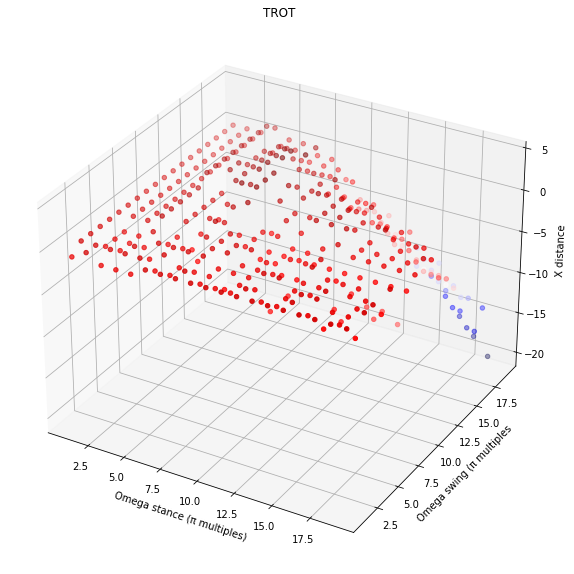

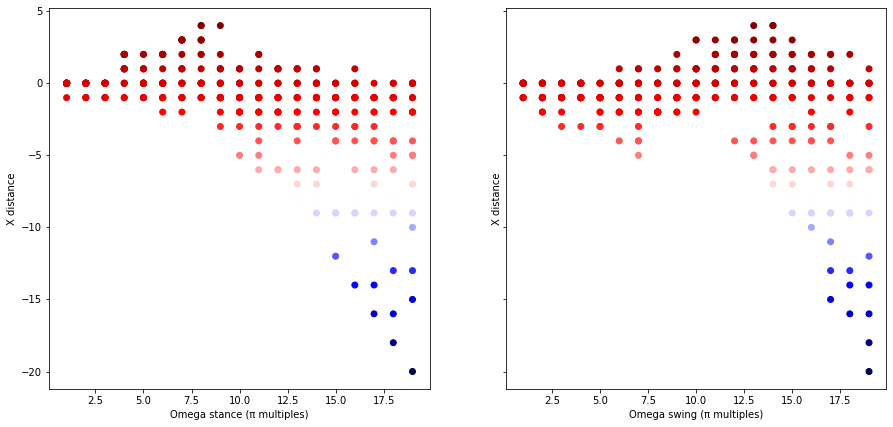

In [19]:
gridded_gait="WALK"

MIN_STANCE_Om = 1*np.pi
MAX_Om = 20*np.pi
Om_steps_width = 1*np.pi
simulation_duration = 10 # (in seconds)

walk_distances = grid_search(gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, 
                             simulation_duration, triangleGridSearch=False, detailedlog=True)
max_and_plot_grid_search(walk_distances, gridded_gait, MIN_STANCE_Om, MAX_Om, 
                         Om_steps_width, triangleGridSearch=False)

#### Grid search for trot

Omega stance=1.0π
    Omega swing=1.0π  with best x dist=0.0
    Omega swing=2.0π  with best x dist=0.0
    Omega swing=3.0π  with best x dist=0.0
    Omega swing=4.0π  with best x dist=0.0
    Omega swing=5.0π  with best x dist=0.1081
    Omega swing=6.0π  with best x dist=0.1533
    Omega swing=7.0π  with best x dist=0.2401
    Omega swing=8.0π  with best x dist=0.3079
    Omega swing=9.0π  with best x dist=0.3079
    Omega swing=10.0π  with best x dist=0.3079
    Omega swing=11.0π  with best x dist=0.3079
    Omega swing=12.0π  with best x dist=0.3079
    Omega swing=13.0π  with best x dist=0.3079
    Omega swing=14.0π  with best x dist=0.314
    Omega swing=15.0π  with best x dist=0.314
    Omega swing=16.0π  with best x dist=0.314
    Omega swing=17.0π  with best x dist=0.314
    Omega swing=18.0π  with best x dist=0.314
    Omega swing=19.0π  with best x dist=0.314
    Omega swing=20.0π  with best x dist=0.314
Omega stance=2.0π
    Omega swing=1.0π  with best x dist=0.314
    Ome

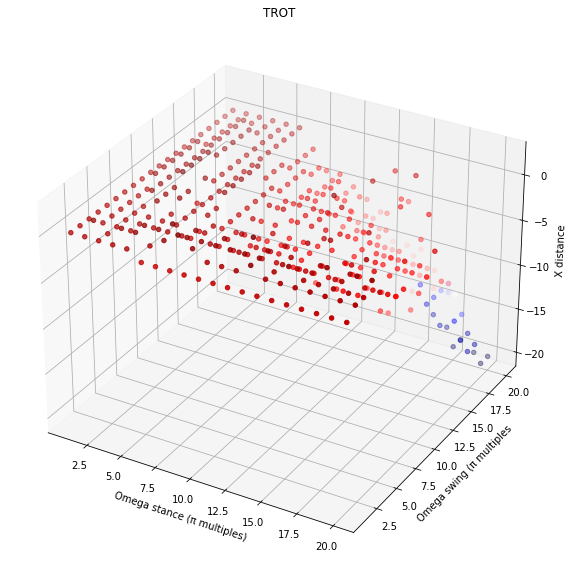

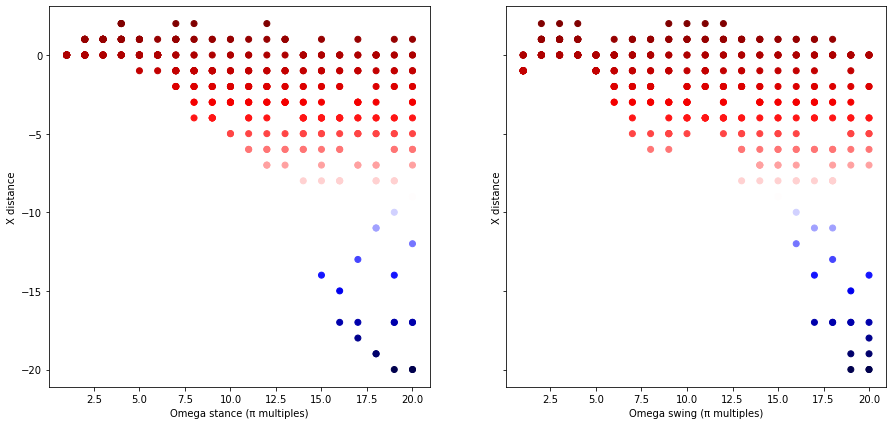

In [66]:
gridded_gait="TROT"            # change depending on desired gait

MIN_STANCE_Om = 1*np.pi
MAX_Om = 20*np.pi
Om_steps_width = 1*np.pi
simulation_duration = 10 # (in seconds)

trot_distances = grid_search(gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, simulation_duration, triangleGridSearch=False, detailedlog=True)
max_and_plot_grid_search(trot_distances, gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, triangleGridSearch=False)

#### Grid search for bound

Omega stance=1.0π
    Omega swing=1.0π  with best x dist=0.0
    Omega swing=2.0π  with best x dist=0.0
    Omega swing=3.0π  with best x dist=0.0
    Omega swing=4.0π  with best x dist=0.0
    Omega swing=5.0π           Robot fell ! with best x dist=0.0
    Omega swing=6.0π           Robot fell ! with best x dist=0.0
    Omega swing=7.0π           Robot fell ! with best x dist=0.0
    Omega swing=8.0π           Robot fell ! with best x dist=0.0
    Omega swing=9.0π           Robot fell ! with best x dist=0.0
    Omega swing=10.0π           Robot fell ! with best x dist=0.2889
    Omega swing=11.0π  with best x dist=0.6809
    Omega swing=12.0π  with best x dist=0.6809
    Omega swing=13.0π  with best x dist=0.7375
    Omega swing=14.0π  with best x dist=0.7375
    Omega swing=15.0π  with best x dist=0.8132
    Omega swing=16.0π  with best x dist=0.8594
    Omega swing=17.0π  with best x dist=0.8886
    Omega swing=18.0π  with best x dist=0.8886
    Omega swing=19.0π  with best x dist=

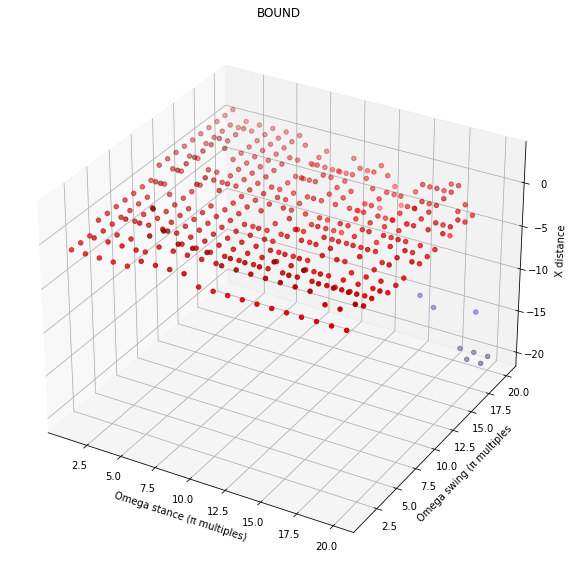

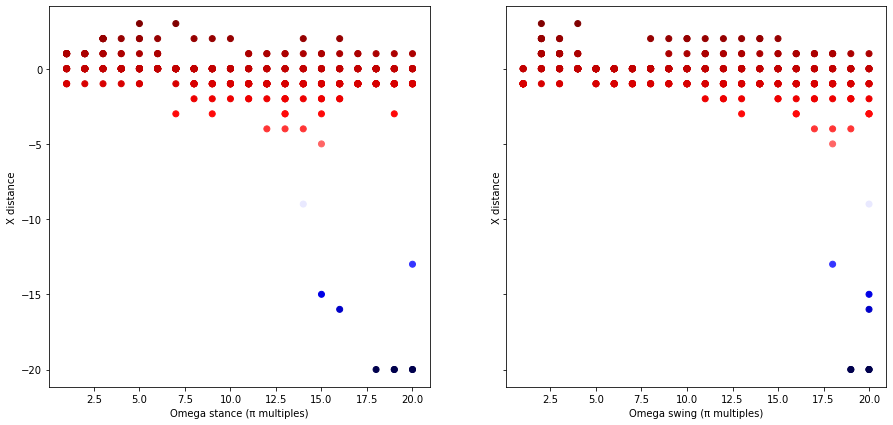

In [67]:
gridded_gait="BOUND"            # change depending on desired gait

MIN_STANCE_Om = 1*np.pi
MAX_Om = 20*np.pi
Om_steps_width = 1*np.pi
simulation_duration = 10 # (in seconds)

bound_distances = grid_search(gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, simulation_duration, triangleGridSearch=False, detailedlog=True)
max_and_plot_grid_search(bound_distances, gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, triangleGridSearch=False)

#### Grid search for pace

Omega stance=1.0π
    Omega swing=1.0π  with best x dist=0.0
    Omega swing=2.0π           Robot fell ! with best x dist=0.0
    Omega swing=3.0π           Robot fell ! with best x dist=0.0
    Omega swing=4.0π  with best x dist=0.0
    Omega swing=5.0π           Robot fell ! with best x dist=0.0
    Omega swing=6.0π  with best x dist=0.0
    Omega swing=7.0π  with best x dist=0.0
    Omega swing=8.0π  with best x dist=0.0
    Omega swing=9.0π  with best x dist=0.0
    Omega swing=10.0π  with best x dist=0.0
    Omega swing=11.0π  with best x dist=0.0
    Omega swing=12.0π  with best x dist=0.0047
    Omega swing=13.0π  with best x dist=0.0874
    Omega swing=14.0π  with best x dist=0.1652
    Omega swing=15.0π  with best x dist=0.2183
    Omega swing=16.0π  with best x dist=0.2183
    Omega swing=17.0π  with best x dist=0.2451
    Omega swing=18.0π  with best x dist=0.2451
    Omega swing=19.0π  with best x dist=0.2451
    Omega swing=20.0π  with best x dist=0.2451
Omega stance=2.0π


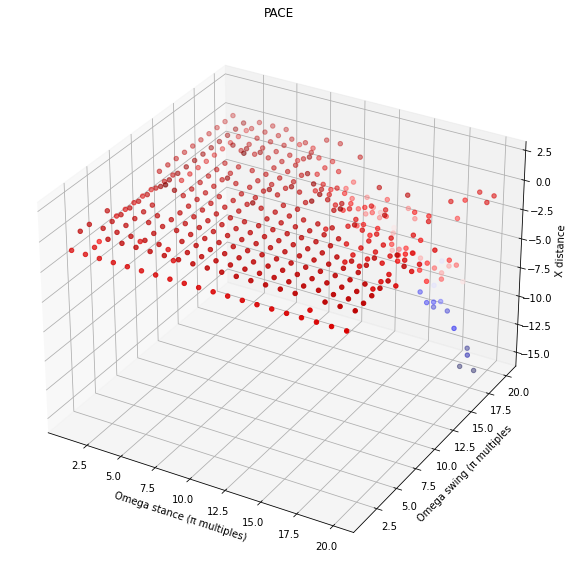

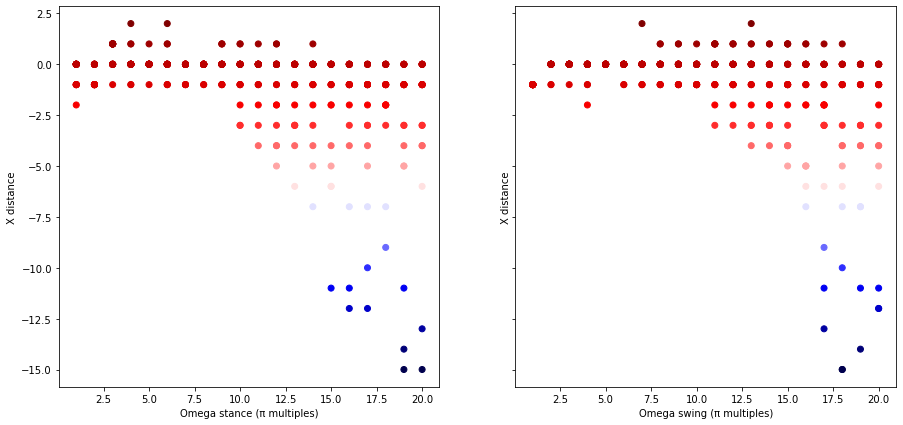

In [68]:
gridded_gait="PACE"            # change depending on desired gait

MIN_STANCE_Om = 1*np.pi
MAX_Om = 20*np.pi
Om_steps_width = 1*np.pi
simulation_duration = 10 # (in seconds)

pace_distances = grid_search(gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, simulation_duration, triangleGridSearch=False, detailedlog=True)
max_and_plot_grid_search(pace_distances, gridded_gait, MIN_STANCE_Om, MAX_Om, Om_steps_width, triangleGridSearch=False)

Best values for gait=PACE are :
max x distance=2.196318828102346
Corresp best Omega stance=6.0π
Corresp best Omega swing=13.0π


Min values are:
min (backwards) x distance=-15.310660365271069
Corresp best Omega stance=20.0π
Corresp best Omega swing=18.0π


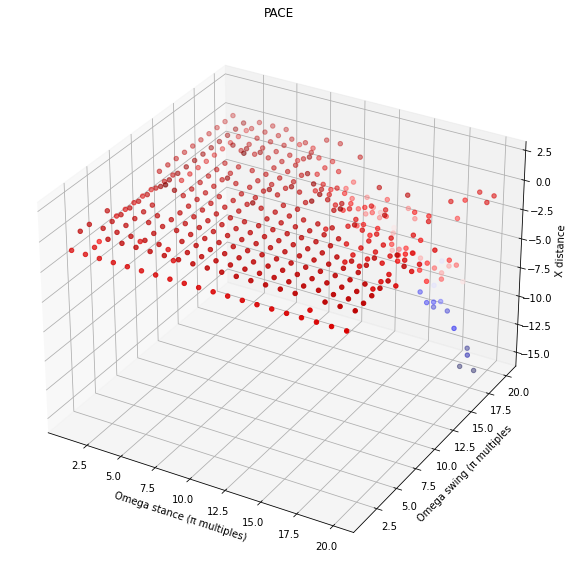

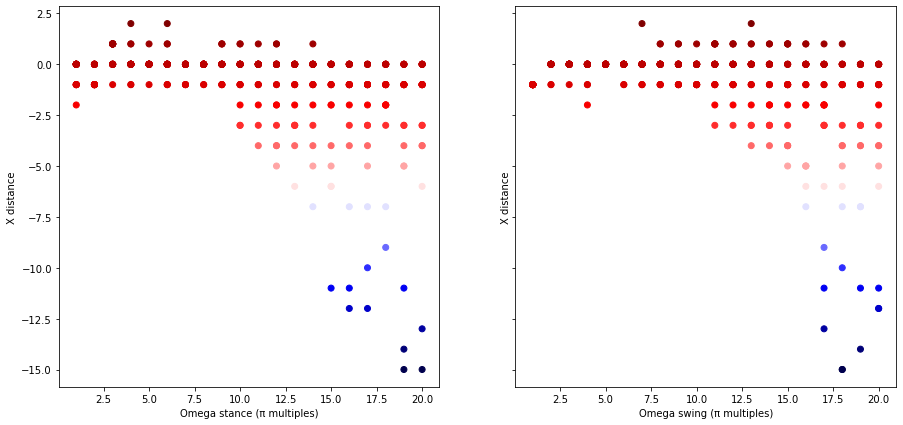

In [78]:
max_and_plot_grid_search(pace_distances, "PACE", MIN_STANCE_Om, MAX_Om, Om_steps_width, triangleGridSearch=False)

#### Notes of raw grid search best results

The best results are gathered here from the simulations above. Note that due to some randomness in the simulation, these values may change depending on runs, but give a good idea nonetheless of good performing parameters. These parameters have also been added to the run_simulation function as defaults for easier simulation in the next steps, without having to re-enter the parameters each time.

**Walk** : Omega stance=8.0π, Omega swing=14.0π with x=4.18
    
    Actual best speed backwards : Omega stance=19π, Omega swing=19π with x=-20.19

**Trot** : Omega stance=12π, Omega swing=4π with x=1.8

    Actual best speed backwards : Omega stance=19π, Omega swing=20π with x=-20.23

**Bound** : Omega stance=5π, Omega swing=4π with x=2.6

    Actual best speed backwards : Omega stance=19π, Omega swing=20π with x=-20.39

**Pace** : Omega stance=6π, Omega swing=13π  with x=2.2

    Actual best speed backwards : Omega stance=20π, Omega swing=18π with x=-15.31

## Explore best simulation / results we got

#### Best walk simulation



In [25]:
# forward optimal
run_simulation(gait="WALK")

(array([ 3.37026278,  0.39528574, -0.05039698]), False)

In [26]:
# backwards optimal
run_simulation(gait="WALK", reverse=True)

(array([-20.17980531,  -1.90354639,  -0.12586061]), True)

#### Best trot simulation

In [27]:
# forward optimal
run_simulation(gait="TROT")

(array([ 1.41527306, -0.23109529, -0.06815734]), False)

In [28]:
# backwards optimal
run_simulation(gait="TROT", reverse=True)

(array([-20.18795019,  -4.25253431,  -0.1251525 ]), True)

#### Best bound simulation

In [32]:
# forward optimal
run_simulation(gait="BOUND")

(array([ 1.51206626, -0.31695594, -0.05625096]), False)

In [36]:
# backwards optimal
run_simulation(gait="BOUND", reverse=True)

(array([-20.32639334,   3.55379821,  -0.12519375]), True)

#### Best pace simulation

In [29]:
# forward optimal
run_simulation(gait="PACE")

(array([ 2.04029889, -0.01546247, -0.04260977]), False)

In [37]:
# backwards optimal
run_simulation(gait="PACE", reverse=True)

(array([-15.20491494,   2.12018196,  -0.06518503]), False)

### Optimize ground penetration

Now let's try a few different ground penetrations. We only try up to a reasonable 0.05 value.

In [46]:
ground_penetrations = [0., 0.01, 0.02, 0.03, 0.04, 0.05]
gaits=["WALK", "TROT", "BOUND", "PACE"]
for gait in gaits:
    for pen in ground_penetrations:
        xyz_dist = np.array([0,0,0])
        fell=False
        for i in range(3): # not all simulations behave same : take best of 3
            temp_xyz, fell = run_simulation(gait, ground_penetration=pen, render=False)
            if(abs(temp_xyz[0])>abs(xyz_dist[0])): xyz_dist = temp_xyz 
        print(f"Dist for gait={gait} at pen={pen} is {xyz_dist} (fell={fell})")
    print("")

Dist for gait=WALK at pen=0.0 is [ 1.98139629  0.5571379  -0.05958779] (fell=False)
Dist for gait=WALK at pen=0.01 is [ 4.14058293 -0.24838513 -0.03857799] (fell=False)
Dist for gait=WALK at pen=0.02 is [ 1.88883415 -0.0245993  -0.0388234 ] (fell=False)
Dist for gait=WALK at pen=0.03 is [-1.14626855 -0.25171532 -0.024789  ] (fell=False)
Dist for gait=WALK at pen=0.04 is [-3.18546483  0.35724068 -0.01224272] (fell=False)
Dist for gait=WALK at pen=0.05 is [-4.35566582  0.31180584 -0.02001511] (fell=False)

Dist for gait=TROT at pen=0.0 is [ 1.08115849 -0.11001488 -0.06826217] (fell=False)
Dist for gait=TROT at pen=0.01 is [ 2.48545037 -0.69007305 -0.06876579] (fell=False)
Dist for gait=TROT at pen=0.02 is [ 1.6430843  -0.82806102 -0.06368477] (fell=False)
Dist for gait=TROT at pen=0.03 is [-0.17603995  0.00210994  0.00324601] (fell=True)
Dist for gait=TROT at pen=0.04 is [-0.18973685  0.04440315  0.01302866] (fell=True)
Dist for gait=TROT at pen=0.05 is [-0.22626428  0.07477637  0.012514

We can see that the ground penetration does not have a big impact, in fact 0.01 seems the best value except for bound where it is larger at 0.02, but in any case the change is minimal.

### Optimize feet swing height

Now let's try a few different feet swing heigts. A reasonable range seems between 0.01 and 0.1

In [42]:
swing_heights = [0.01, 0.03, 0.05, 0.08, 0.1]
gaits=["WALK", "TROT", "BOUND", "PACE"]
for gait in gaits:
    for height in swing_heights:
        xyz_dist = np.array([0,0,0])
        fell=False
        for i in range(3): # not all simulations behave same : take best of 3
            temp_xyz, fell = run_simulation(gait, swing_height=height, render=False)
            if(abs(temp_xyz[0])>abs(xyz_dist[0])): xyz_dist = temp_xyz 
        print(f"Dist for gait={gait} at height={height} is {xyz_dist} (fell={fell})")
    print("")

Dist for gait=WALK at height=0.01 is [-3.305045   -0.70509526 -0.02959634] (fell=False)
Dist for gait=WALK at height=0.03 is [-1.42415961  0.19358634 -0.06025599] (fell=False)
Dist for gait=WALK at height=0.05 is [ 4.20455216  0.14912008 -0.03978867] (fell=False)
Dist for gait=WALK at height=0.08 is [ 4.04486969  0.08297519 -0.04530396] (fell=False)
Dist for gait=WALK at height=0.1 is [ 4.28539422  0.14977008 -0.03233959] (fell=False)

Dist for gait=TROT at height=0.01 is [-1.45481658  0.27903489 -0.05582695] (fell=False)
Dist for gait=TROT at height=0.03 is [ 0.1504247   0.11547197 -0.06513296] (fell=False)
Dist for gait=TROT at height=0.05 is [ 1.15617215  0.44381803 -0.07122536] (fell=False)
Dist for gait=TROT at height=0.08 is [-0.02375276  0.00425974 -0.12514253] (fell=True)
Dist for gait=TROT at height=0.1 is [-0.01695638  0.00715147 -0.12536244] (fell=True)

Dist for gait=BOUND at height=0.01 is [-0.17569829  0.05131567 -0.02715504] (fell=False)
Dist for gait=BOUND at height=0.0

We can see that the best value is indeed the default one of 0.05. We can see however that with 0.1 it start getting good results for both walk and pace, which might be due to a new equilibrium being met.

### With more or less coupling

In [43]:
couplings = [0, 1, 2, 5, 10]
gaits=["WALK", "TROT", "BOUND", "PACE"]
for gait in gaits:
    for coupling in couplings:
        xyz_dist = np.array([0,0,0])
        fell=False
        for i in range(3): # not all simulations behave same : take best of 3
            temp_xyz, fell = run_simulation(gait, coupling_strength=coupling, render=False)
            if(abs(temp_xyz[0])>abs(xyz_dist[0])): xyz_dist = temp_xyz 
        print(f"Dist for gait={gait} at coupling={coupling} is {xyz_dist} (fell={fell})")
    print("")

Dist for gait=WALK at coupling=0 is [ 2.57661712 -1.62097472 -0.04091267] (fell=False)
Dist for gait=WALK at coupling=1 is [ 4.10677538 -0.04274811 -0.04580877] (fell=False)
Dist for gait=WALK at coupling=2 is [ 2.56011929  0.51429013 -0.05426682] (fell=False)
Dist for gait=WALK at coupling=5 is [ 2.86674543  1.41219494 -0.05459298] (fell=False)
Dist for gait=WALK at coupling=10 is [ 1.03985838  0.08078757 -0.05923988] (fell=False)

Dist for gait=TROT at coupling=0 is [-0.15497929 -0.00314974 -0.0558939 ] (fell=True)
Dist for gait=TROT at coupling=1 is [ 2.03697849 -0.09085975 -0.06521777] (fell=False)
Dist for gait=TROT at coupling=2 is [ 1.32436819  0.54390732 -0.02891128] (fell=False)
Dist for gait=TROT at coupling=5 is [ 1.03204639  0.09258213 -0.06742227] (fell=True)
Dist for gait=TROT at coupling=10 is [ 0.97583201 -0.11545694 -0.06335543] (fell=False)

Dist for gait=BOUND at coupling=0 is [ 1.16515025e+00 -1.65615865e-01  5.24233114e-05] (fell=True)
Dist for gait=BOUND at coupli

Again we can see that the default of 1 is a good value. It could be due to the fine tuning we have done using this parameter, but it would be way to long to perform multi-d grid search with coupling as a new parameter.

### Test Cartesian PD

### Optimize mu

Now we'll try different mu, just to see if it makes an impact.

In [45]:
mussqrts = [0, 1, 2, 5]
gaits=["WALK", "TROT", "BOUND", "PACE"]
for gait in gaits:
    for mu in mussqrts:
        xyz_dist = np.array([0,0,0])
        fell=False
        for i in range(3): # not all simulations behave same : take best of 3
            temp_xyz, fell = run_simulation(gait, musqrt=mu, render=False)
            if(abs(temp_xyz[0])>abs(xyz_dist[0])): xyz_dist = temp_xyz 
        print(f"Dist for gait={gait} at musqrt={mu} is {xyz_dist} (fell={fell})")
    print("")

Dist for gait=WALK at musqrt=0 is [-4.07470405  1.09479304 -0.04827138] (fell=False)
Dist for gait=WALK at musqrt=1 is [ 3.52582094 -0.68535348 -0.04576952] (fell=False)
Dist for gait=WALK at musqrt=2 is [-0.53134747  0.21894647 -0.01584205] (fell=True)
Dist for gait=WALK at musqrt=5 is [-0.10157826 -0.00623929  0.04380289] (fell=True)

Dist for gait=TROT at musqrt=0 is [ 0.8654065   0.34448965 -0.03035245] (fell=False)
Dist for gait=TROT at musqrt=1 is [ 2.3712521  -0.76303938 -0.06506309] (fell=False)
Dist for gait=TROT at musqrt=2 is [0.7039586  0.35558368 0.04421117] (fell=True)
Dist for gait=TROT at musqrt=5 is [-0.28725274  0.11901796  0.0350731 ] (fell=True)

Dist for gait=BOUND at musqrt=0 is [ 0.87295674 -0.00238069 -0.06488863] (fell=False)
Dist for gait=BOUND at musqrt=1 is [ 2.62497848  0.21300699 -0.03627459] (fell=False)
Dist for gait=BOUND at musqrt=2 is [-0.53700825 -0.0496728  -0.00583083] (fell=True)
Dist for gait=BOUND at musqrt=5 is [-0.04406926  0.00035759 -0.00010

Only for pace are the rults slighly improved with a musqrt!=1, but overall 1 is good.

## Detailed graphs

Let's look in different ways at the performance we have achieved.

# TODO

In [ ]:
##################################################### 
# PLOTS
#####################################################
# example
# fig = plt.figure()
# plt.plot(t,joint_pos[1,:], label='FR thigh')
# plt.legend()
# plt.show()

In [ ]:
# time.sleep(2)
pybullet.disconnect()